<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Python" data-toc-modified-id="Python-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Python</a></span></li></ul></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Weather" data-toc-modified-id="Weather-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Weather</a></span></li><li><span><a href="#Shapefiles" data-toc-modified-id="Shapefiles-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Shapefiles</a></span></li><li><span><a href="#Population-density" data-toc-modified-id="Population-density-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Population density</a></span></li><li><span><a href="#Generating-population-weighted-daily-regional-averages" data-toc-modified-id="Generating-population-weighted-daily-regional-averages-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Generating population-weighted daily regional averages</a></span></li><li><span><a href="#Covid-19" data-toc-modified-id="Covid-19-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Covid-19</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Splitting-in-waves?" data-toc-modified-id="Splitting-in-waves?-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>Splitting in waves?</a></span></li></ul></li><li><span><a href="#SDC" data-toc-modified-id="SDC-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>SDC</a></span></li><li><span><a href="#Visualizing-overrepresented-ranges" data-toc-modified-id="Visualizing-overrepresented-ranges-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Visualizing overrepresented ranges</a></span><ul class="toc-item"><li><span><a href="#All-time" data-toc-modified-id="All-time-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>All time</a></span><ul class="toc-item"><li><span><a href="#Temperature" data-toc-modified-id="Temperature-3.2.1.1"><span class="toc-item-num">3.2.1.1&nbsp;&nbsp;</span>Temperature</a></span></li><li><span><a href="#Absolute-Humidity" data-toc-modified-id="Absolute-Humidity-3.2.1.2"><span class="toc-item-num">3.2.1.2&nbsp;&nbsp;</span>Absolute Humidity</a></span></li></ul></li><li><span><a href="#Splitting-by-periods" data-toc-modified-id="Splitting-by-periods-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Splitting by periods</a></span><ul class="toc-item"><li><span><a href="#Temperature" data-toc-modified-id="Temperature-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Temperature</a></span></li><li><span><a href="#Absolute-Humidity" data-toc-modified-id="Absolute-Humidity-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Absolute Humidity</a></span></li></ul></li></ul></li></ul></li></ul></div>

# COVID19 and climate in European NUTS2 regions

## Preamble

### Imports

#### Python

In [2]:
import sys
sys.path.append('..')

In [9]:
import os
import pickle
import cdsapi
import warnings
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import plotnine as p9
import geopandas as gpd
import matplotlib.pyplot as plt


from atmos import calculate
from covid19dh import covid19
from collections import defaultdict


from tqdm.auto import tqdm
from metpy.units import units
from shapely.geometry import Point
from mizani.breaks import date_breaks
from metpy.calc import relative_humidity_from_dewpoint
from mizani.formatters import date_format, percent_format
from sdcpy.scale_dependent_correlation import SDCAnalysis

from src import CV_LABELS
from src.utils import region_assign

In [23]:
p9.options.set_option("dpi", 150)
p9.themes.theme_set(p9.theme_bw)
plt.style.use("seaborn-whitegrid")
plt.ioff()
plt.rcParams.update({"figure.max_open_warning": 0})
tqdm.pandas()

## Data

### Weather

In [13]:
c = cdsapi.Client()

In [ ]:
for year, month in zip([2020] * 11 +  [2021], list(range(2, 13)) + [1]):
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': ['2m_dewpoint_temperature', '2m_temperature', 'total_precipitation', 'surface_pressure'],
            'year': year,
            'grid': [0.25, 0.25],
            'month': [str(month).zfill(2)],
            'day': [str(i).zfill(2) for i in range(1, 32)],
            'time': [f'{str(i).zfill(2)}:00' for i in range(23)],
            'area': [
                56, # Latitude North (max)
                -10, # Longitude West (min)
                36, # Latitude South (min)
                18, # Longitude East (max)
            ],
            'format': 'netcdf',
        },
        f'../../data/era5/EU_regions/eu_{year}_{month}.nc')

In [ ]:
nc_files = [f for f in os.listdir('../../data/era5/EU_regions/') if f[-2:]=='nc']

In [ ]:
for file in tqdm(nc_files, leave=False, desc='Processing NC file'):
    xr_file = xr.load_dataset(f'../../data/era5/EU_regions/{file}')
    xr_file.d2m.attrs['units'] = 'degK'
    xr_file.t2m.attrs['units'] = 'degK'
    xr_file.msl.attrs['units'] = 'Pa'
    xr_file.tp.attrs['units'] = 'm'
    (xr_file
     .assign(rh=lambda dd: relative_humidity_from_dewpoint(dd.t2m, dd.d2m))
     .resample(time='1D')
     .mean()
     .metpy.dequantify()
     .to_dataframe()
     .reset_index()
     .assign(longitude=lambda dd: dd.longitude.apply(lambda x: x if x < 180 else x - 360))
     # To avoid computation of cells not allocated to any country:
     .merge(lon_lat_region)
     .dropna()
     # we want the total precipitation in mm, not the hourly mean for the day in m, so:
     .assign(tp=lambda dd: dd.tp * 24 * 1000)
     .assign(ah=lambda dd: calculate('AH', RH=dd.rh * 100, p=dd.msl, T=dd.t2m) * 1000)
     .rename(columns={'t2m': 'temperature',
                      'tp': 'total_precipitation',
                      'rh': 'relative_humidity',
                      'ah': 'absolute_humidity',
                      'time': 'date'})
     .assign(temperature=lambda dd: dd.temperature - 273.15)
     [['date', 'latitude', 'longitude', 'country', 'temperature', 'absolute_humidity',
       'relative_humidity', 'total_precipitation']]
     .to_pickle(f'../../data/era5/EU_regions/processed/{file.split(".")[0]}.pickle')
    )

In [17]:
eu4_weather = (pd.concat([pd.read_pickle(f'../../data/era5/EU_regions//processed/{f}')
                         for f in os.listdir('../../data/era5/EU_regions/processed')])
              .sort_values(['latitude', 'longitude', 'date'])
               .dropna()
              )

### Shapefiles

For some reason, German landers are classified as NUTS1 regions, so we will fetch shapefiles for the Spanish and Italian NUTS2 regions and German NUTS1 regions from GISCO (an Eurostat service)

In [20]:
nuts2 = gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/'
                      'nuts/shp/NUTS_RG_10M_2021_4326_LEVL_2.shp.zip')

In [21]:
nuts1 = (gpd.read_file('https://gisco-services.ec.europa.eu/distribution/v2/'
                      'nuts/shp/NUTS_RG_10M_2021_4326_LEVL_1.shp.zip')
         .loc[lambda dd: dd.CNTR_CODE=='DE']
        )

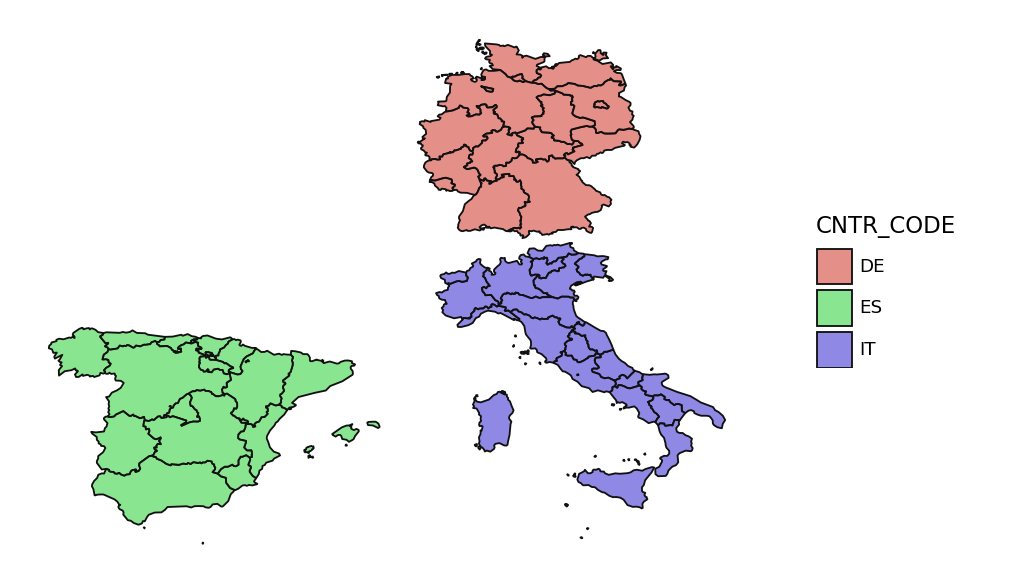

<ggplot: (8774518925556)>

In [25]:
eu4_regions = (nuts2
                 .loc[lambda dd: dd.CNTR_CODE.isin(['ES', 'IT'])]
                 .append(nuts1)
                 .pipe(lambda dd: pd.concat([dd, dd.geometry.bounds], axis=1))
                 .loc[lambda dd: dd.minx>-10]
                 .loc[lambda dd: dd.miny > 20]
            )

eu4_regions.pipe(lambda dd: p9.ggplot(dd)
                 + p9.geom_map(p9.aes(fill='CNTR_CODE'), alpha=.7)
                 + p9.theme_void())

In [26]:
lon_lat_region = (eu4_weather
                  [['longitude', 'latitude']]
                  .drop_duplicates()
                  .assign(region=lambda dd:
                          [region_assign(lon, lat, eu4_regions, 'NUTS_NAME', .25)
                           for lon, lat in tqdm(zip(dd.longitude, dd.latitude),
                                                     leave=False, total=dd.shape[0])])
                  .dropna()
)

  0%|          | 0/9153 [00:00<?, ?it/s]

In [29]:
lon_lat_region.to_csv('../../data/coords_region_EU_regions.csv')

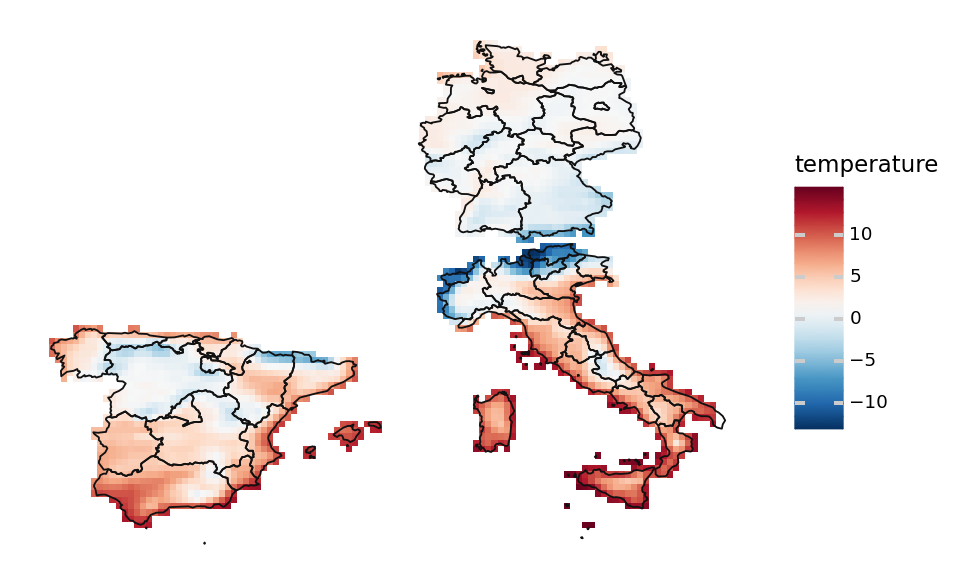

<ggplot: (8774517932746)>

In [30]:
(eu4_weather
 .loc[lambda dd: dd.date=='2021-01-01']
 .merge(lon_lat_region)
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('longitude', 'latitude', fill='temperature')
       + p9.geom_tile()
       + p9.scale_fill_continuous('RdBu_r')
       + p9.geom_map(data=eu4_regions, inherit_aes=False, alpha=0, fill=None)
       + p9.theme_void())
)

### Population density

In [33]:
dens = (
    xr.load_dataset("../../data/density_grid/gpw_v4_population_density_rev11_2pt5_min.nc")
    .sel({"raster": 4})
    .to_dataframe()
    .dropna()
    .reset_index()
    .drop(columns="raster")
    .rename(
        columns={
            "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
        }
    )
    # Here I am first, rounding up to .25 resolution and then shifting the map so that longitudes
    # are on the -180 +180 domain. 
    .assign(latitude=lambda dd: (dd.latitude * 4).round() / 4)
    .assign(longitude=lambda dd: (dd.longitude * 4).round() / 4)
    .groupby(["latitude", "longitude"])
    .mean()
    .reset_index()
)

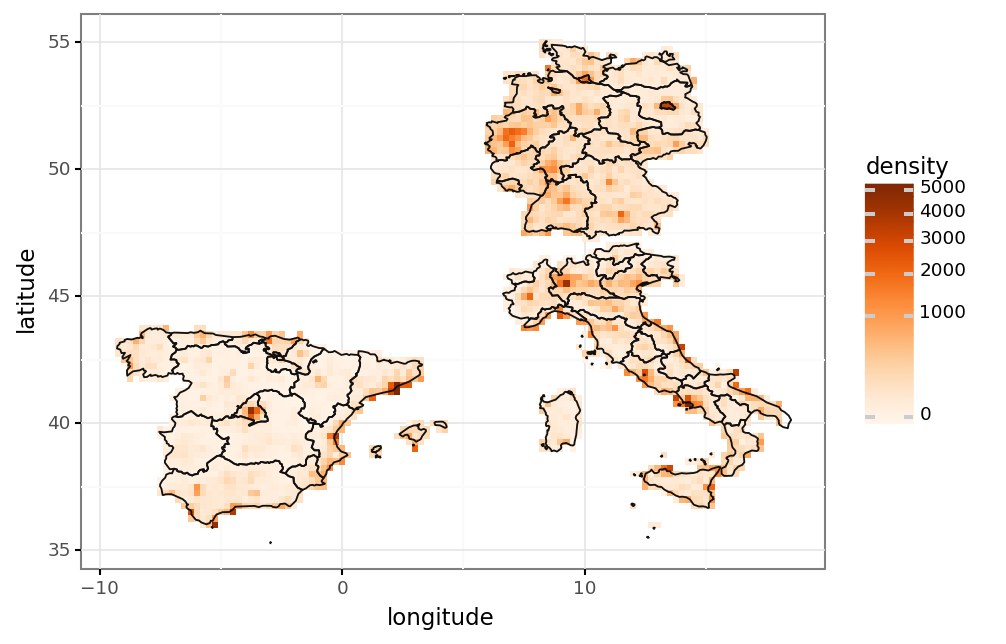

<ggplot: (8774517737024)>

In [34]:
(dens
 .merge(lon_lat_region)
  .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('longitude', 'latitude', fill='density')
       + p9.geom_tile()
       + p9.scale_fill_continuous('Oranges', trans='sqrt', limits=(0, 5000))
       + p9.geom_map(data=eu4_regions, inherit_aes=False, alpha=0, fill=None))
)

### Generating population-weighted daily regional averages

In [35]:
weighted_cells = (
    dens.merge(lon_lat_region)
    .groupby('region', as_index=False)
    .apply(
        lambda gdd: gdd.assign(
            relative_weight=lambda gdd: gdd.density / gdd.density.sum()
        )
    )
    .reset_index(drop=True)
)

In [36]:
weighted_climate_df = (
    weighted_cells
    .dropna()
    .merge(eu4_weather.merge(lon_lat_region), on=["latitude", "longitude", "region"])
    .assign(
        temperature=lambda dd: dd.temperature * dd.relative_weight,
        absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight * 1000, # convert to g/m³
        total_precipitation=lambda dd: dd.total_precipitation * dd.relative_weight * 1000, # convert to mm
        relative_humidity=lambda dd: dd.relative_humidity * dd.relative_weight * 100, # convert to % 
    )
    .groupby(['region', "date"])
    .agg({"temperature": "sum",
          "absolute_humidity": "sum",
          "relative_humidity": "sum",
          "total_precipitation": "sum"})
    .reset_index()
    .assign(region=lambda dd: dd.region.replace({'Valle d’Aosta/Vallée d’Aoste': "Valle d'Aosta"}))
    .melt(['region', 'date'])
    .assign(region=lambda dd: dd.region.str.replace('/', '-'))
    .sort_values(['region', 'date'])
    
)

### Covid-19

In [37]:
covid_eu4, src = covid19(['Germany', 'Italy', 'Spain'], level=2, verbose=False)

In [38]:
covid_eu4['administrative_area_level_2'] = (covid_eu4
                                             .administrative_area_level_2
                                             .str.replace('<U+00F4>', 'ô', regex=False)
                                             .str.replace('<U+00FC>', 'ü', regex=False)
                                             .str.replace('<U+00E9>', 'é', regex=False)
                                             .str.replace('<U+00F3>', 'ó', regex=False)
                                             .str.replace('<U+00ED>', 'í', regex=False)
                                             .str.replace('<U+00CE>', 'Î', regex=False)
                                             .str.replace('<U+00F1>', 'ñ', regex=False)
)

In [39]:
covid_sdc_df = (covid_eu4
                .loc[covid_eu4.iso_alpha_2.isin(['ES', 'IT', 'DE'])]
                .rename(columns={'administrative_area_level_2': 'region',
                                 'iso_alpha_3': 'iso3'})
                [['date', 'iso3', 'region', 'confirmed']]
                .dropna()
                .groupby(['iso3', 'region'])
                .apply(lambda dd: dd.sort_values('date').assign(new_cases=lambda dd: dd.confirmed.diff().fillna(0)))
                .reset_index(drop=True)
                .assign(region=lambda dd: dd.region.replace({'Ceuta': 'Ciudad de Ceuta',
                                                         'Comunidad Valenciana': 'Comunitat Valenciana',
                                                         'Friuli Venezia Giulia': 'Friuli-Venezia Giulia',
                                                         'Islas Baleares': 'Illes Balears',
                                                         'Melilla': 'Ciudad de Melilla',
                                                         'P.A. Bolzano': 'Provincia Autonoma di Bolzano/Bozen',
                                                         'P.A. Trento': 'Provincia Autonoma di Trento',
                                                         }))
               )

In [41]:
weighted_climate_df.to_csv('../../data/weather_eu.csv', index=False)

In [42]:
covid_sdc_df.to_csv('../../data/covid_eu.csv', index=False)

In [43]:
regions_country = covid_sdc_df[['region', 'iso3']].drop_duplicates().set_index('region').to_dict()['iso3']

## Analysis

Let's remove the data for Spain after the 20th of January 2021, as it was not updated at the time of the analysis

In [46]:
covid_sdc_df = (covid_sdc_df
                 .assign(new_cases=lambda dd: np.where((dd.iso3=='ESP') 
                                                       & (dd.date>'2021-01-21'),
                                                       np.NaN, dd.new_cases))
                 .dropna()
                .loc[lambda dd: dd.date < '2021-02']
)

#### Splitting in waves?

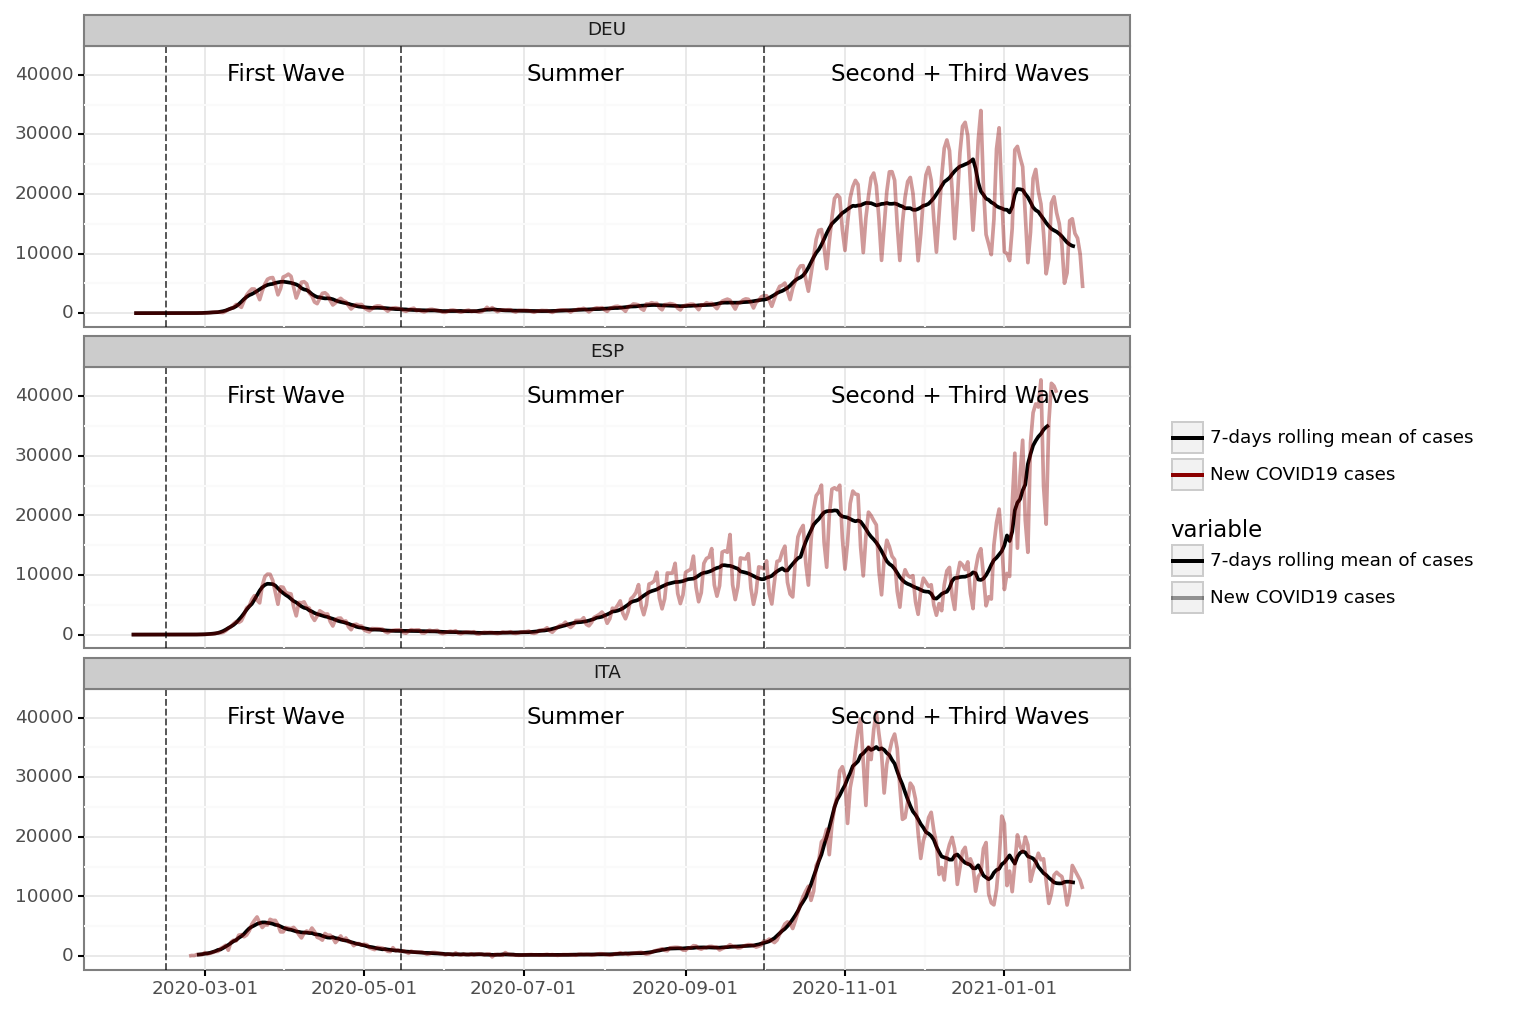

<ggplot: (8774513184711)>

In [47]:
(covid_sdc_df
 .groupby(['date', 'iso3'])
 .new_cases
 .sum()
 .reset_index()
 .groupby('iso3')
 .apply(lambda dd: dd.assign(roll=lambda dd: dd.new_cases.rolling(center=True, window=7).mean()))
 .reset_index(drop=True)
 .melt(['iso3', 'date'])
 .replace({'roll': '7-days rolling mean of cases',
           'new_cases': 'New COVID19 cases'})
 .loc[lambda dd: dd.date > '2020-02-01']
 .pipe(lambda dd: p9.ggplot(dd)
       + p9.aes('date', 'value', color='variable', alpha='variable')
       + p9.facet_wrap(['iso3'], ncol=1)
       + p9.geom_line(size=1)
       + p9.scale_color_manual(['black', 'darkred'])
       + p9.scale_alpha_manual([1, .4])
       + p9.theme(figure_size=(9, 8))
       + p9.geom_vline(xintercept='2020-02-15', linetype='dashed', alpha=.7)
       + p9.geom_vline(xintercept='2020-05-15', linetype='dashed', alpha=.7)
       + p9.annotate(geom='text', y=40000, x='2020-04-01', label='First Wave')
       + p9.geom_vline(xintercept='2020-10-01', linetype='dashed', alpha=.7)
       + p9.annotate(geom='text', y=40000, x='2020-07-21', label='Summer')
       + p9.annotate(geom='text', y=40000, x='2020-12-15', label='Second + Third Waves')
       + p9.labs(x='', y='', color='')
      )
)

### SDC

In [ ]:
out_dir_tab = '../../results/tables/SDC_EU'
out_dir_fig = '../../results/figures/SDC_EU'

In [53]:
covid_sdc_df = (covid_sdc_df
                .query('date > "2020-02-15"')
                .assign(period=lambda dd: dd.date.apply(lambda x:
                                        '(1) Early Wave' if x <= pd.to_datetime('2020-05-15') else 
                                       ('(2) Summer' if x < pd.to_datetime('2020-10-01') else
                                        '(3) Late Waves')))
                .loc[lambda dd: dd.region.isin(weighted_climate_df.region.unique())]
)

In [54]:
weighted_climate_df = \
(weighted_climate_df
 .assign(period=lambda dd: dd.date.apply(lambda x:
                 '(1) Early Wave' if x <= pd.to_datetime('2020-05-15') else 
                 ('(2) Summer' if x < pd.to_datetime('2020-10-01') else
                 '(3) Late Waves')))
)

In [ ]:
ranges_df = []
errors_list = {}
window = 21
sdcs = {}
out_dir_tab = '../../results/tables/SDC_EU'
out_dir_fig = '../../results/figures/SDC_EU'

for region in tqdm(covid_sdc_df.region.unique(), leave=False, desc='Regions'):
    country = regions_country[region]
    for var in tqdm(['temperature', 'absolute_humidity'], leave=False, desc='Weather variables'):
        for period in covid_sdc_df['period'].unique():
            os.makedirs(f"{out_dir_fig}/{country}/window_21/{region}/{period}", exist_ok=True)
            os.makedirs(f"{out_dir_fig}/{country}/window_21/{region}/{period}", exist_ok=True)
            w = (weighted_climate_df
                 .query(f'region=="{region}" & variable=="{var}" & period=="{period}"')
                 .set_index('date')
                 .value)

            c = (covid_sdc_df
                 .query(f'region=="{region}" & period=="{period}"')
                 .set_index('date')
                 .new_cases
                 .rolling(center=True, window=7)
                 .mean()
                 .dropna())
        
            bin_size = 2 if var == 'absolute_humidity' else 3
            max_bin = 22 if var == 'absolute_humidity' else 32
            min_bin = 0 if var == 'absolute_humidity' else -6
            sdc = SDCAnalysis(w, c, fragment_size=window, min_lag=-21, max_lag=0, method='spearman')
            sdcs[f'{region}_{var}_{period}'] = sdc

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                try:
                    ranges_df.append(sdc.get_ranges_df(bin_size=bin_size, min_bin=min_bin, max_bin=max_bin)
                                      .assign(region=region, var=var, country=regions_country[region],
                                              period=period))

                except Exception as e:
                    errors_list[f'{region}_{var}'] = e

In [73]:
ranges_df = pd.concat(ranges_df)
ranges_df.to_csv('../../results/tables/ranges_eu_regions.csv', index=False)

In [64]:
with open('../../data/intermediate_files/eu_sdcs.pickle', 'wb') as fh:
    pickle.dump(sdcs, fh)

In [ ]:
with open('../../data/intermediate_files/eu_sdcs.pickle', 'rb') as fh:
    sdcs = pickle.load(fh)

### Visualizing overrepresented ranges

#### All time

##### Temperature

In [75]:
wv = 'temperature'

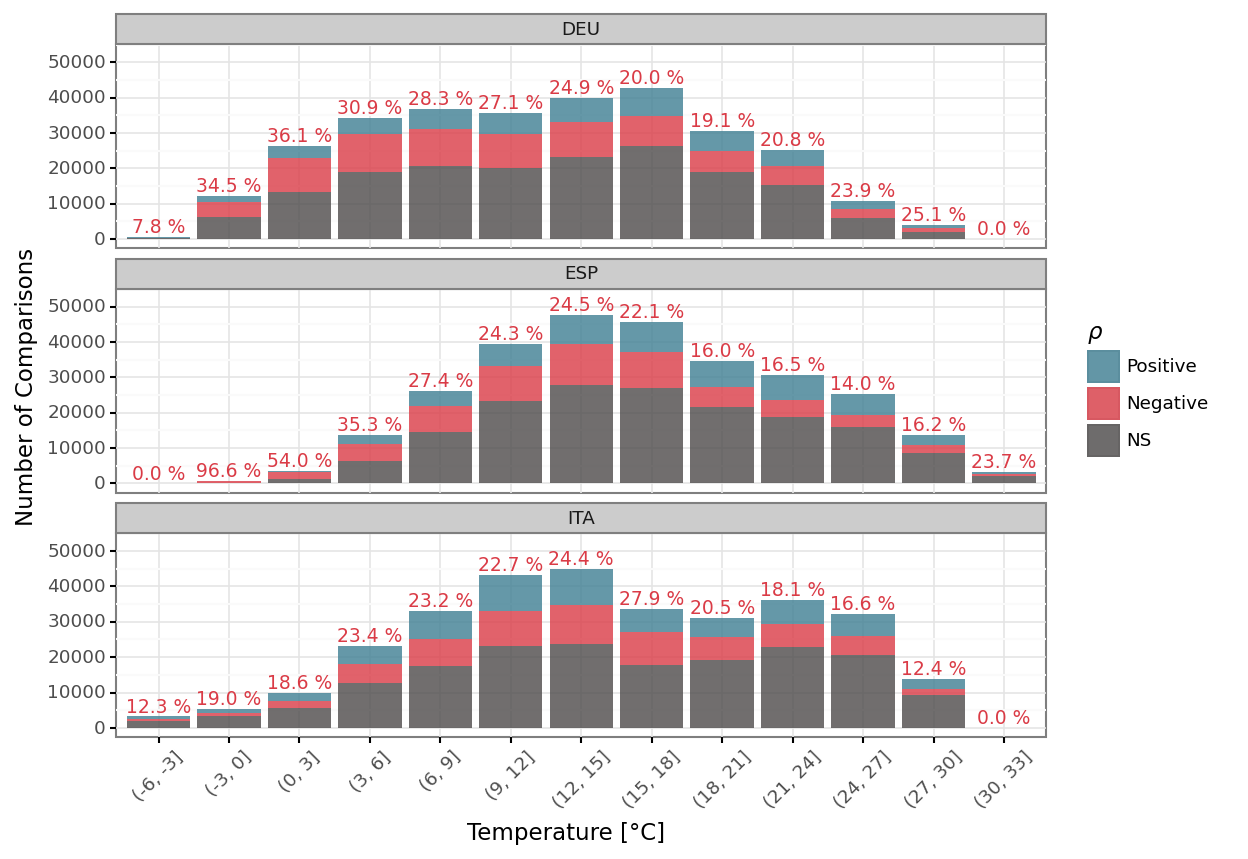

In [93]:
(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .groupby(['direction', 'cat_value', 'country'])
 .agg({'counts': 'sum', 'n': 'sum'})
 .reset_index()
 .assign(freq=lambda dd: (dd.counts / dd.n).fillna(0))
 .assign(label=lambda dd: (dd.freq * 100).round(1).astype(str) + ' %')
 .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'counts', fill='direction')
               + p9.geom_col(alpha=.8)
               + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=45))
               + p9.facet_wrap(['country'], ncol=1)
               + p9.scale_fill_manual(['#3f7f93', '#da3b46', '#4d4a4a'])
               + p9.labs(x=CV_LABELS[wv], y='Number of Comparisons', fill='$\\rho$')
               + p9.geom_text(p9.aes(label='label', x='cat_value', y='n + max(n) * .06'),
                              inherit_aes=False, size=9,
                               data=dd.loc[dd['direction'] == 'Negative'], color='#da3b46')
              + p9.ylim(0, dd.n.max() * 1.1)

               )
 
).draw().savefig('../../results/figures/ranges_eu_regions_bars_t.pdf', bbox_inches='tight')

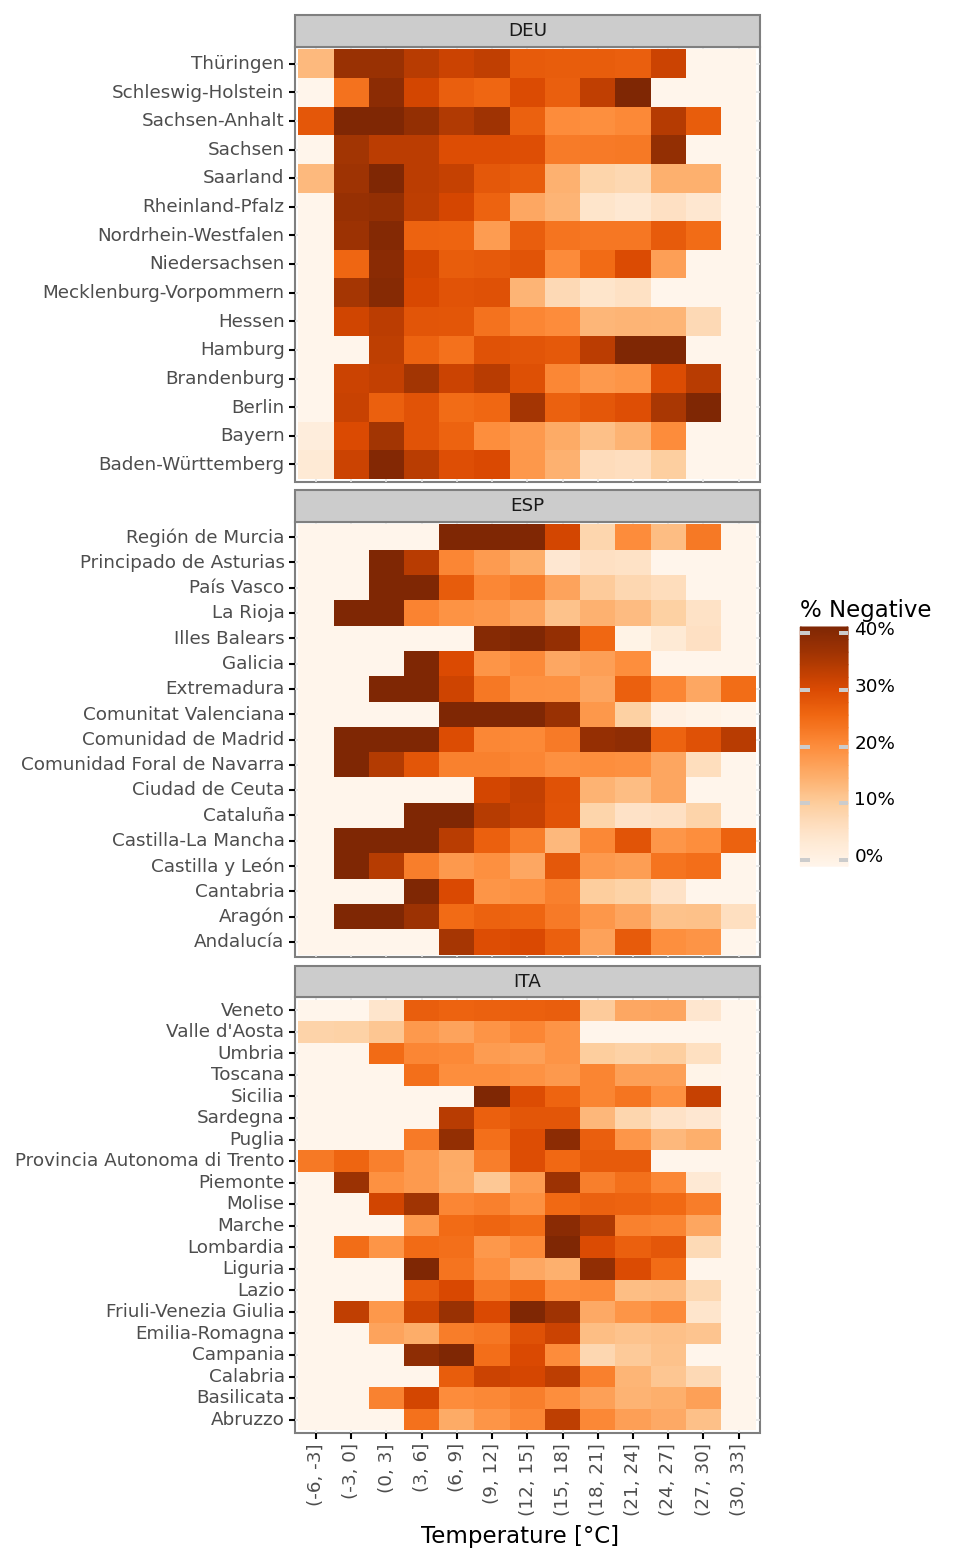

In [94]:
(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .loc[lambda dd: dd.direction=='Negative']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
  .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'region', fill='freq')
               + p9.geom_tile()
               + p9.facet_wrap('country', ncol=1, scales='free_y')
               + p9.theme(figure_size=(4, 12), axis_text_x=p9.element_text(rotation=90))
               + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
               + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
               )
).draw().savefig('../../results/figures/ranges_eu_regions_heatmap_t.pdf', bbox_inches='tight')

##### Absolute Humidity

In [81]:
wv = 'absolute_humidity'

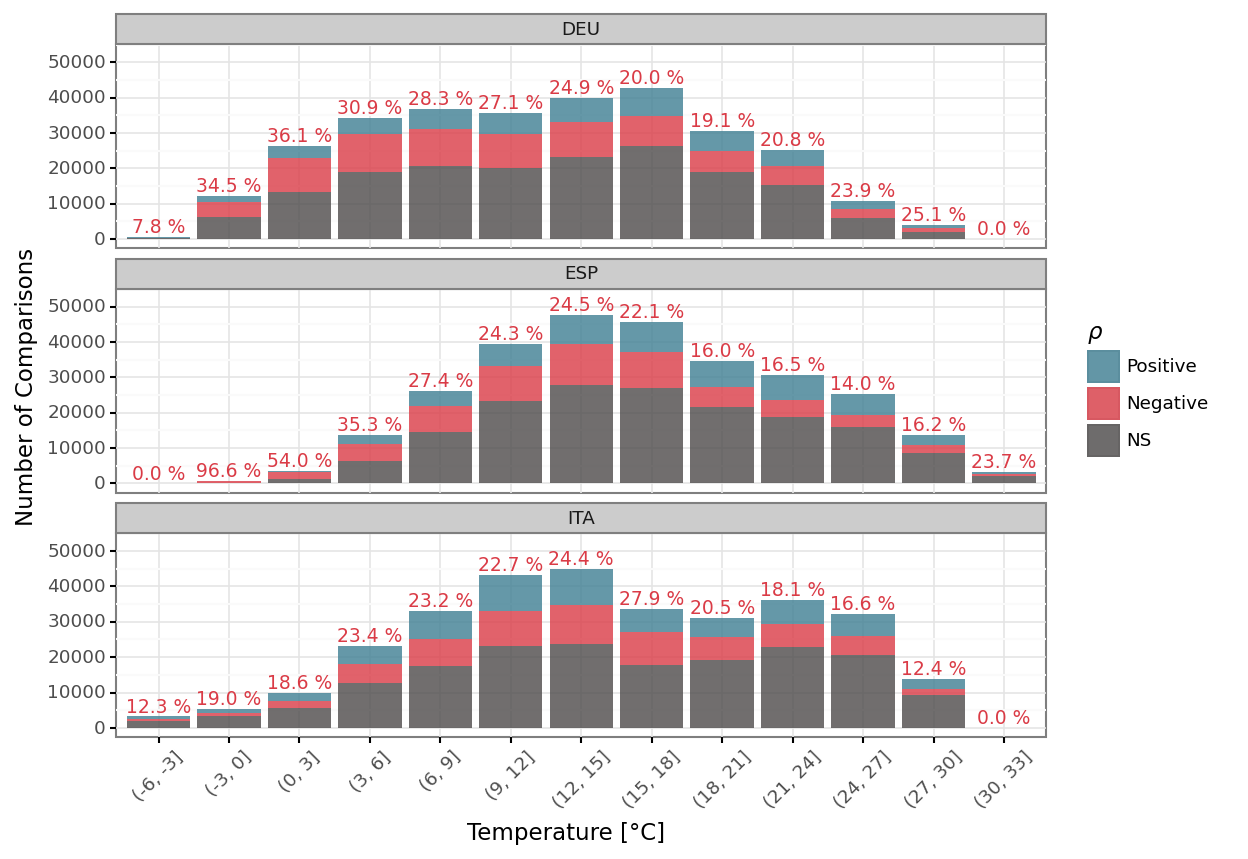

In [92]:
(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .groupby(['direction', 'cat_value', 'country'])
 .agg({'counts': 'sum', 'n': 'sum'})
 .reset_index()
 .assign(freq=lambda dd: (dd.counts / dd.n).fillna(0))
 .assign(label=lambda dd: (dd.freq * 100).round(1).astype(str) + ' %')
 .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'counts', fill='direction')
               + p9.geom_col(alpha=.8)
               + p9.theme(figure_size=(8, 6), axis_text_x=p9.element_text(rotation=45))
               + p9.facet_wrap(['country'], ncol=1)
               + p9.scale_fill_manual(['#3f7f93', '#da3b46', '#4d4a4a'])
               + p9.labs(x=CV_LABELS[wv], y='Number of Comparisons', fill='$\\rho$')
               + p9.geom_text(p9.aes(label='label', x='cat_value', y='n + max(n) * .06'), inherit_aes=False, size=9,
                               data=dd.loc[dd['direction'] == 'Negative'], color='#da3b46')
              + p9.ylim(0, dd.n.max() * 1.1)

               )
 
).draw().savefig('../../results/figures/ranges_eu_regions_bars_ah.pdf', bbox_inches='tight')

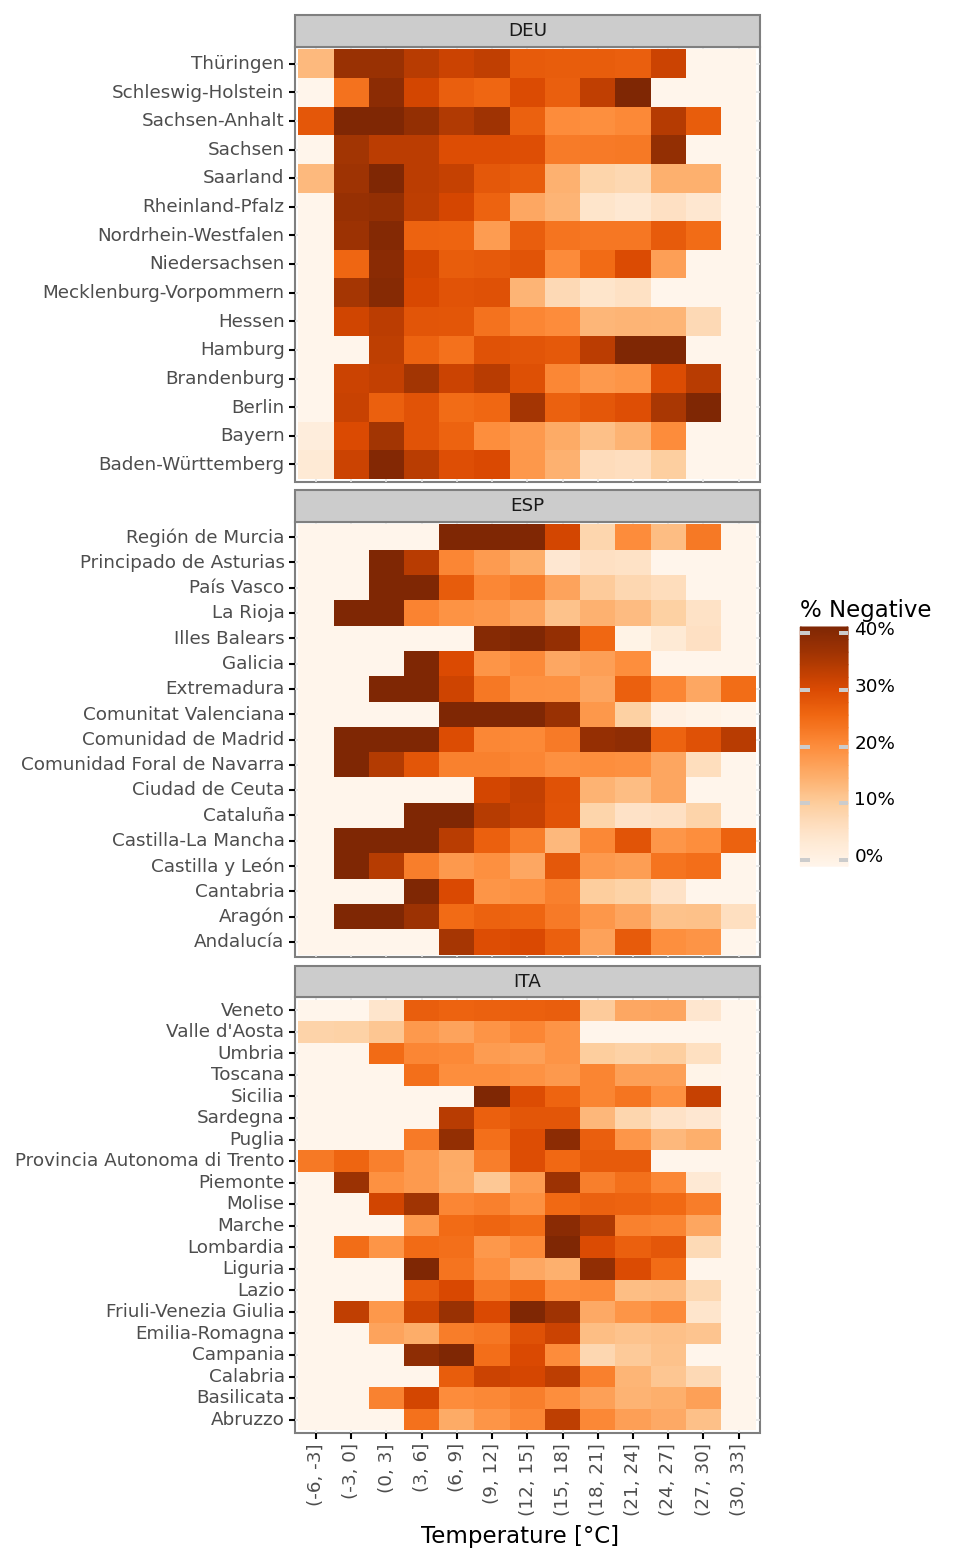

In [91]:
(ranges_df
 .loc[lambda dd: dd['var']==wv]
 .loc[lambda dd: dd.direction=='Negative']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
  .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'region', fill='freq')
               + p9.geom_tile()
               + p9.facet_wrap('country', ncol=1, scales='free_y')
               + p9.theme(figure_size=(4, 12), axis_text_x=p9.element_text(rotation=90))
               + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
               + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
               )
).draw().savefig('../../results/figures/ranges_eu_regions_heatmap_ah.pdf', bbox_inches='tight')

#### Splitting by periods

##### Temperature

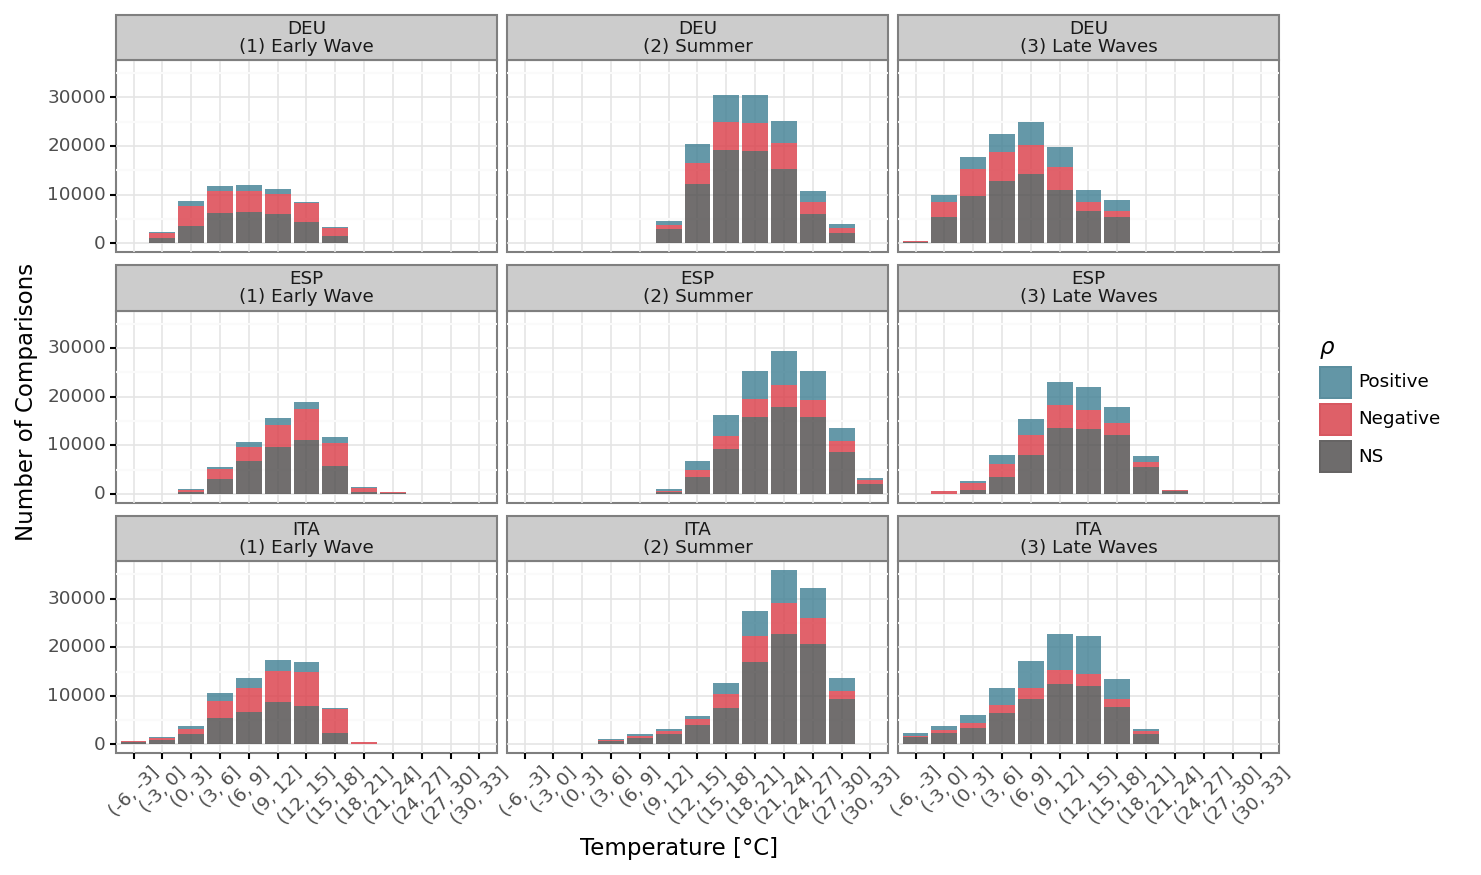

In [95]:
wv = 'temperature'
f = (ranges_df
     .loc[lambda dd: dd['var']==wv]
     .groupby(['direction', 'cat_value', 'country', 'period'], as_index=False)
     .sum()
     .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'counts', fill='direction')
               + p9.geom_col(alpha=.8)
               + p9.theme(figure_size=(10, 6), axis_text_x=p9.element_text(rotation=45))
               + p9.facet_wrap(['country', 'period'], ncol=3)
               + p9.scale_fill_manual(['#3f7f93', '#da3b46', '#4d4a4a'])
               + p9.labs(x=CV_LABELS[wv], y='Number of Comparisons', fill='$\\rho$')
               )
 
)
f.draw().savefig('../../results/figures/ranges_eu_regions_bars_t_periods.pdf', bbox_inches='tight')

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 4 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/ranges_DEU_periods_heatmap_t.pdf
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 4 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/ranges_ESP_periods_heatmap_t.pdf
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 10 x 4 in image.
/home/afontal/.cache/pypoetry/virtualenvs/c

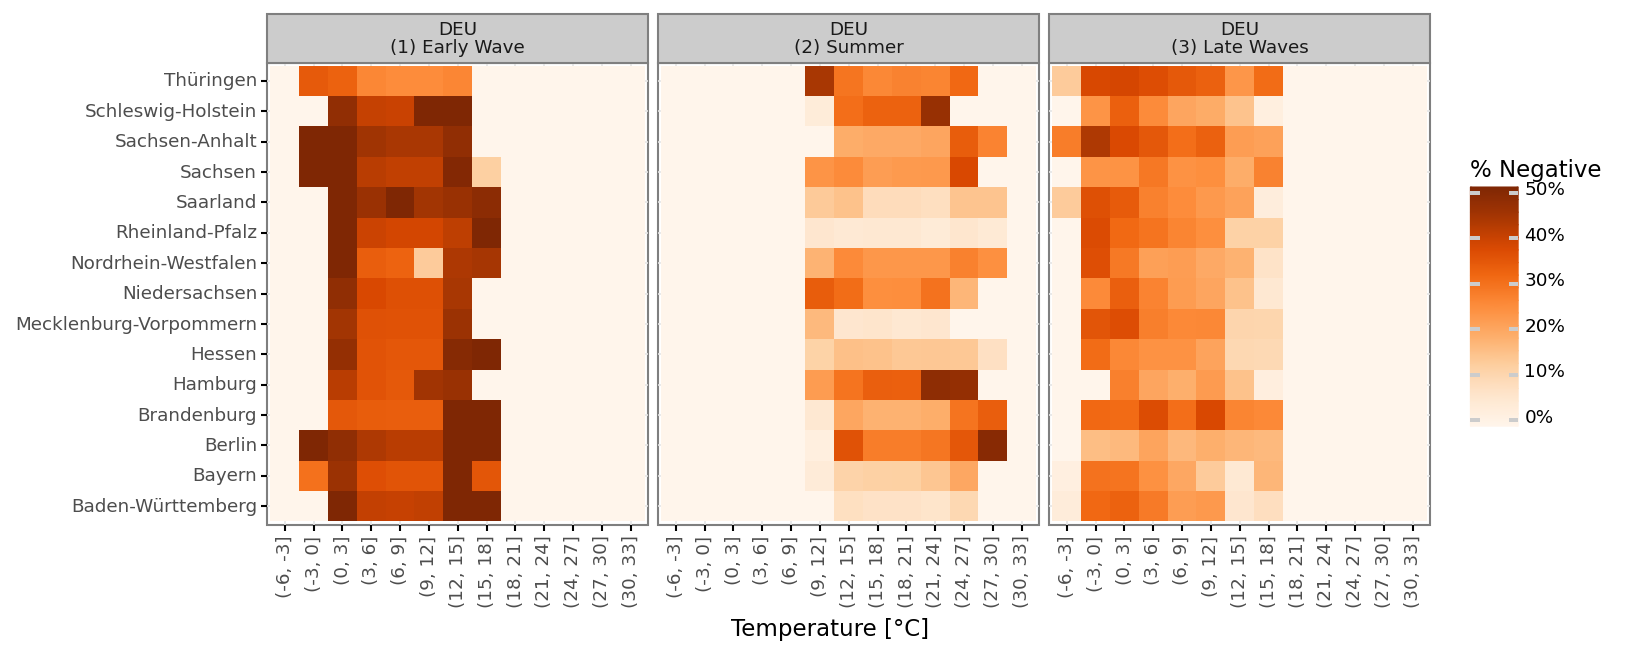

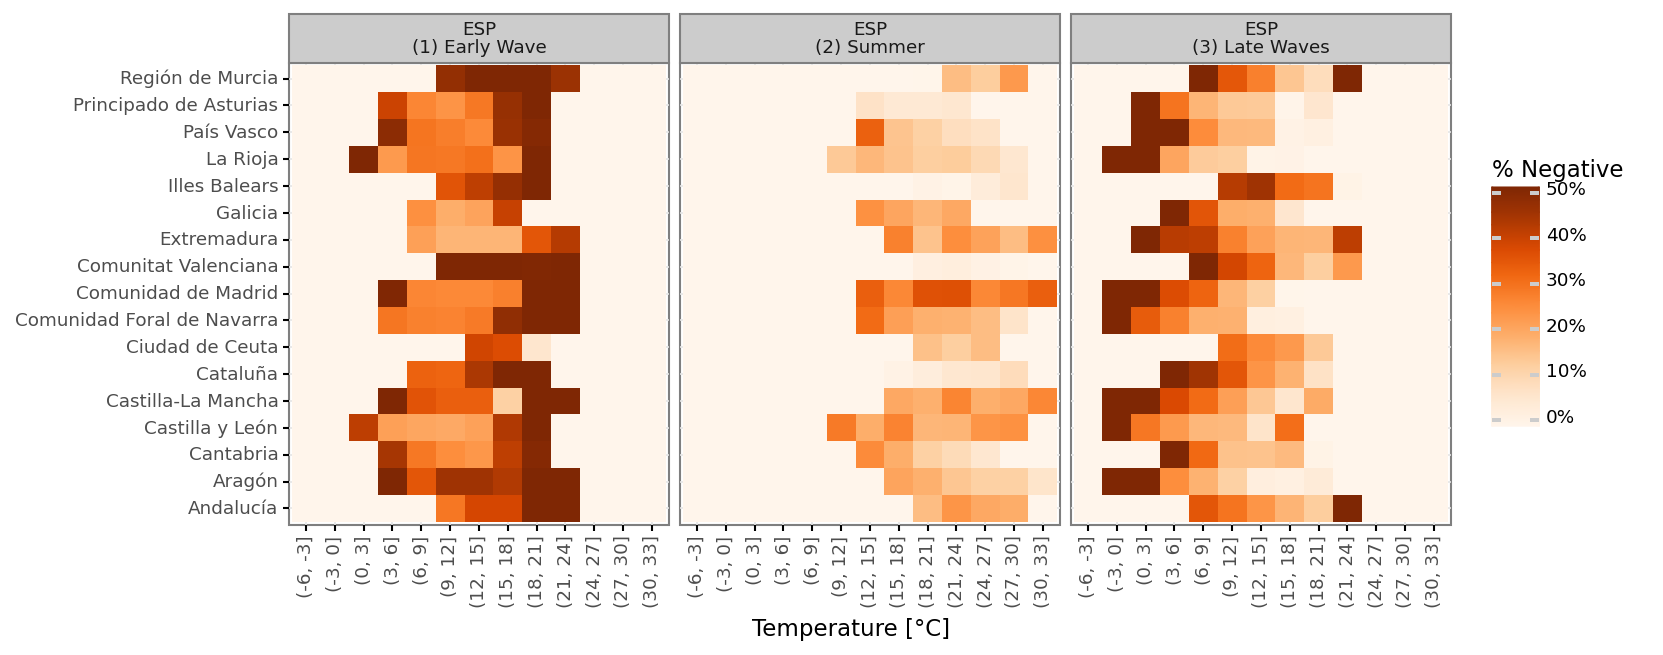

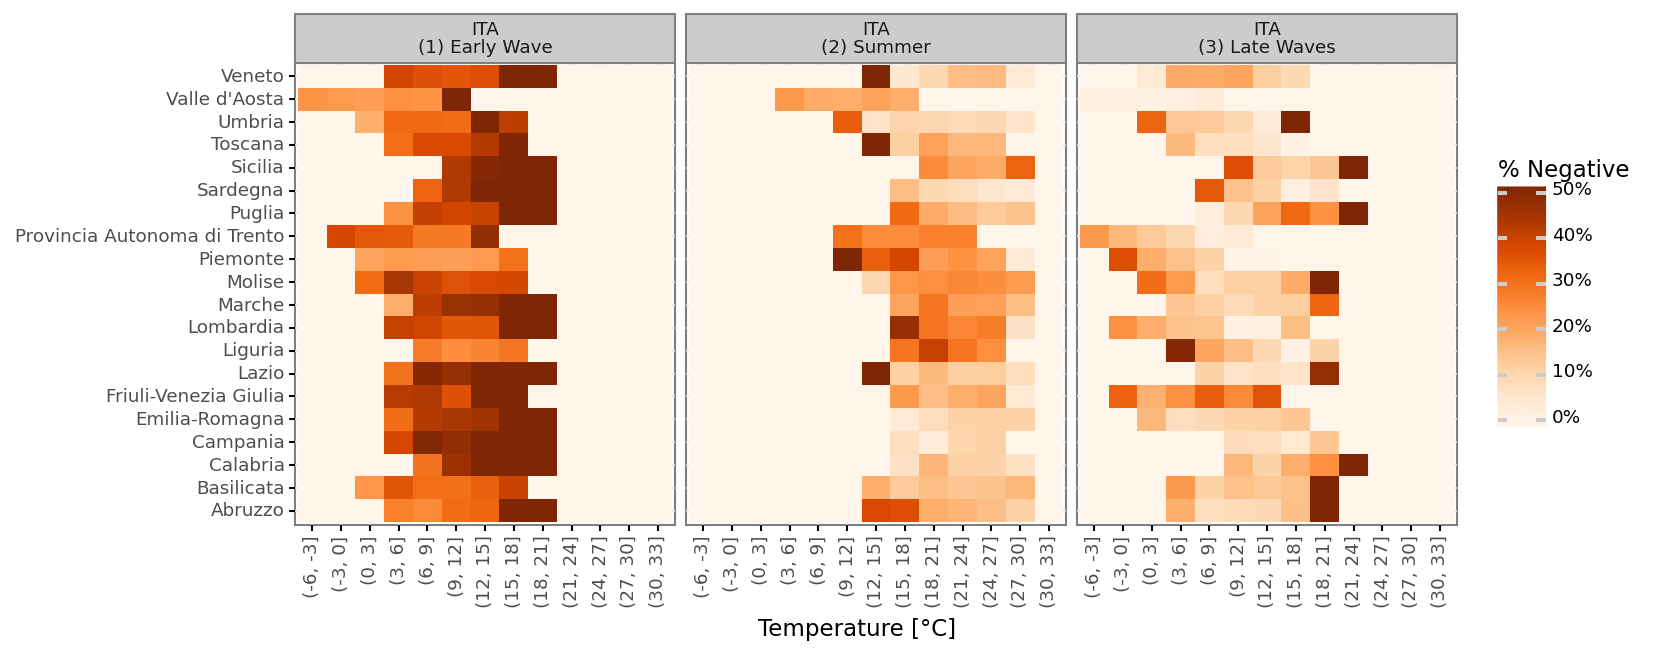

In [98]:
for country in ['DEU', 'ESP', 'ITA']:
    f = (ranges_df
     .loc[lambda dd: dd['var']==wv]
     .loc[lambda dd: dd['country']==country]
     .loc[lambda dd: dd.direction=='Negative']
      .pipe(lambda dd: p9.ggplot(dd)
                   + p9.aes('cat_value', 'region', fill='freq')
                   + p9.geom_tile()
                   + p9.facet_wrap(['country', 'period'], ncol=3)
                   + p9.theme(figure_size=(10, 4), axis_text_x=p9.element_text(rotation=90))
                   + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .5))
                   + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
                   )
    )
    p9.ggsave(f, f'../../results/figures/ranges_{country}_periods_heatmap_t.pdf')
    f.draw()
plt.show()

##### Absolute Humidity

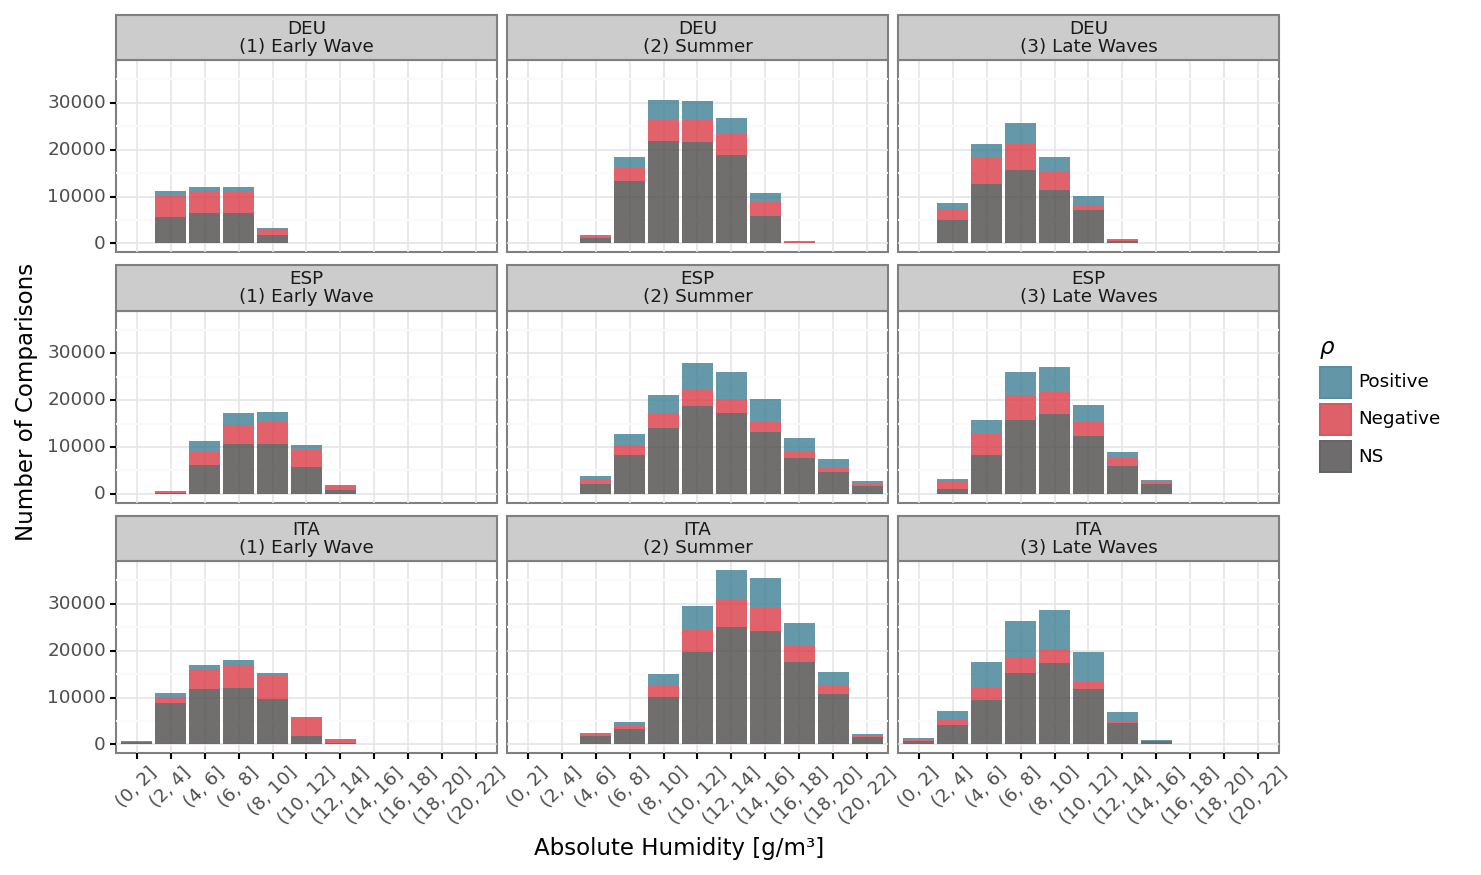

In [99]:
wv = 'absolute_humidity'
f = (ranges_df
     .loc[lambda dd: dd['var']==wv]
     .groupby(['direction', 'cat_value', 'country', 'period'], as_index=False)
     .sum()
     .pipe(lambda dd: p9.ggplot(dd)
               + p9.aes('cat_value', 'counts', fill='direction')
               + p9.geom_col(alpha=.8)
               + p9.theme(figure_size=(10, 6), axis_text_x=p9.element_text(rotation=45))
               + p9.facet_wrap(['country', 'period'], ncol=3)
               + p9.scale_fill_manual(['#3f7f93', '#da3b46', '#4d4a4a'])
               + p9.labs(x=CV_LABELS[wv], y='Number of Comparisons', fill='$\\rho$')
               )
 
)
f.draw().savefig('../../results/figures/ranges_eu_regions_bars_ah_periods.pdf', bbox_inches='tight')

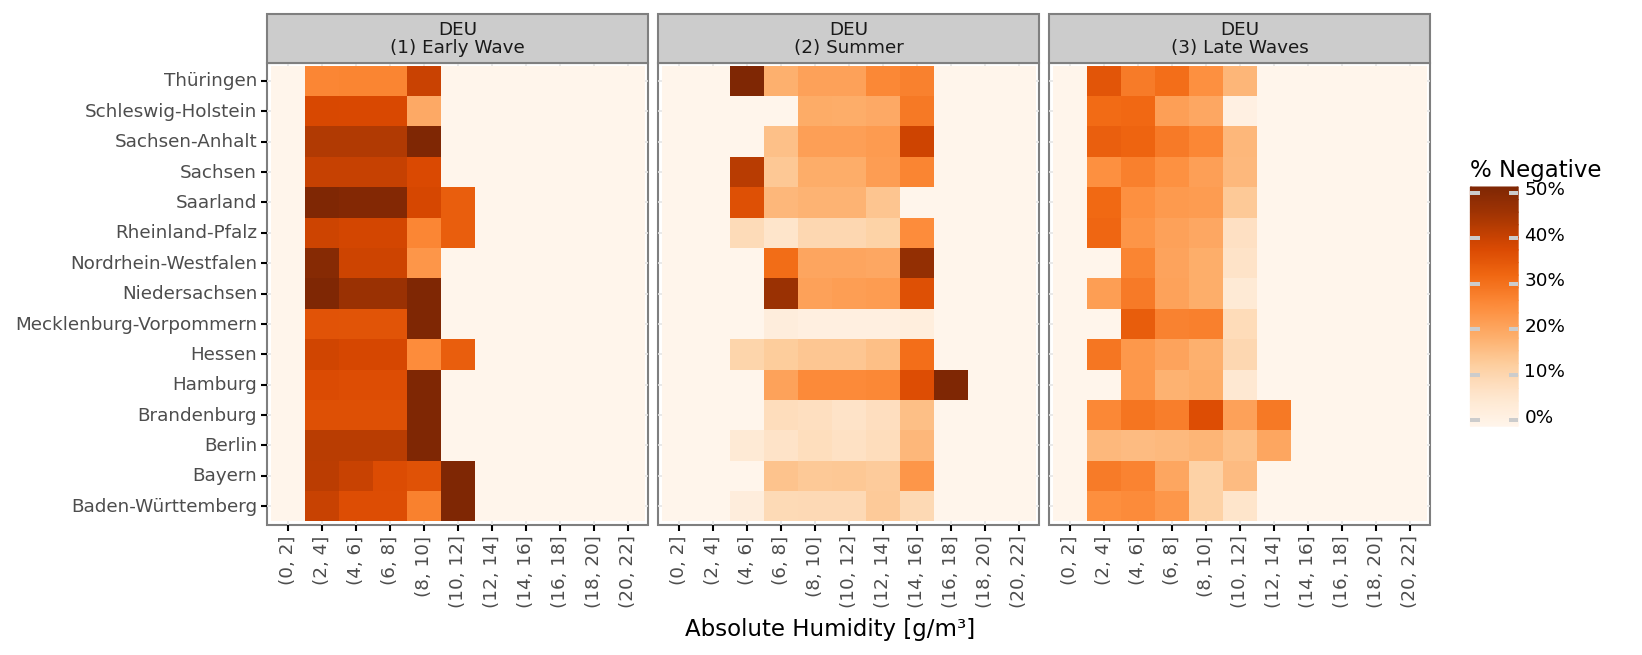

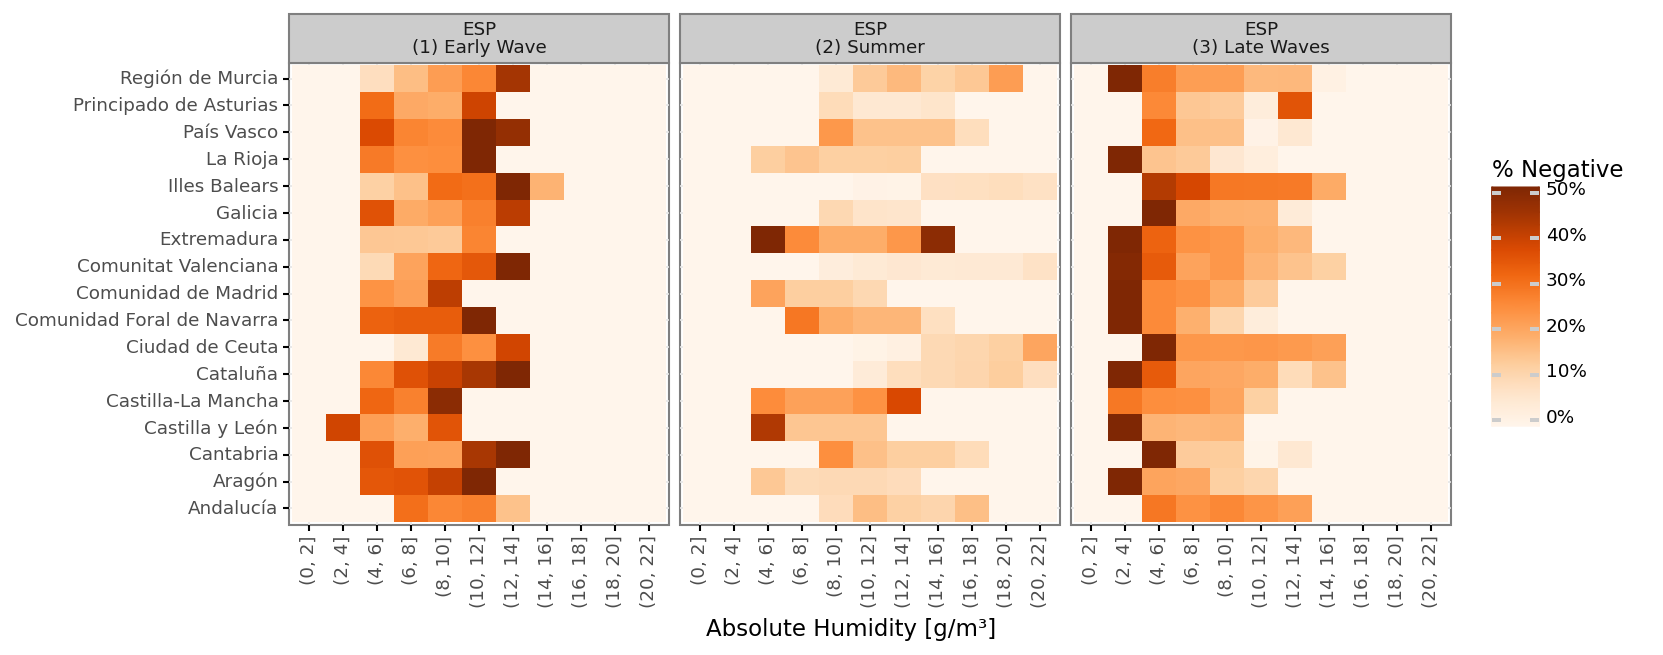

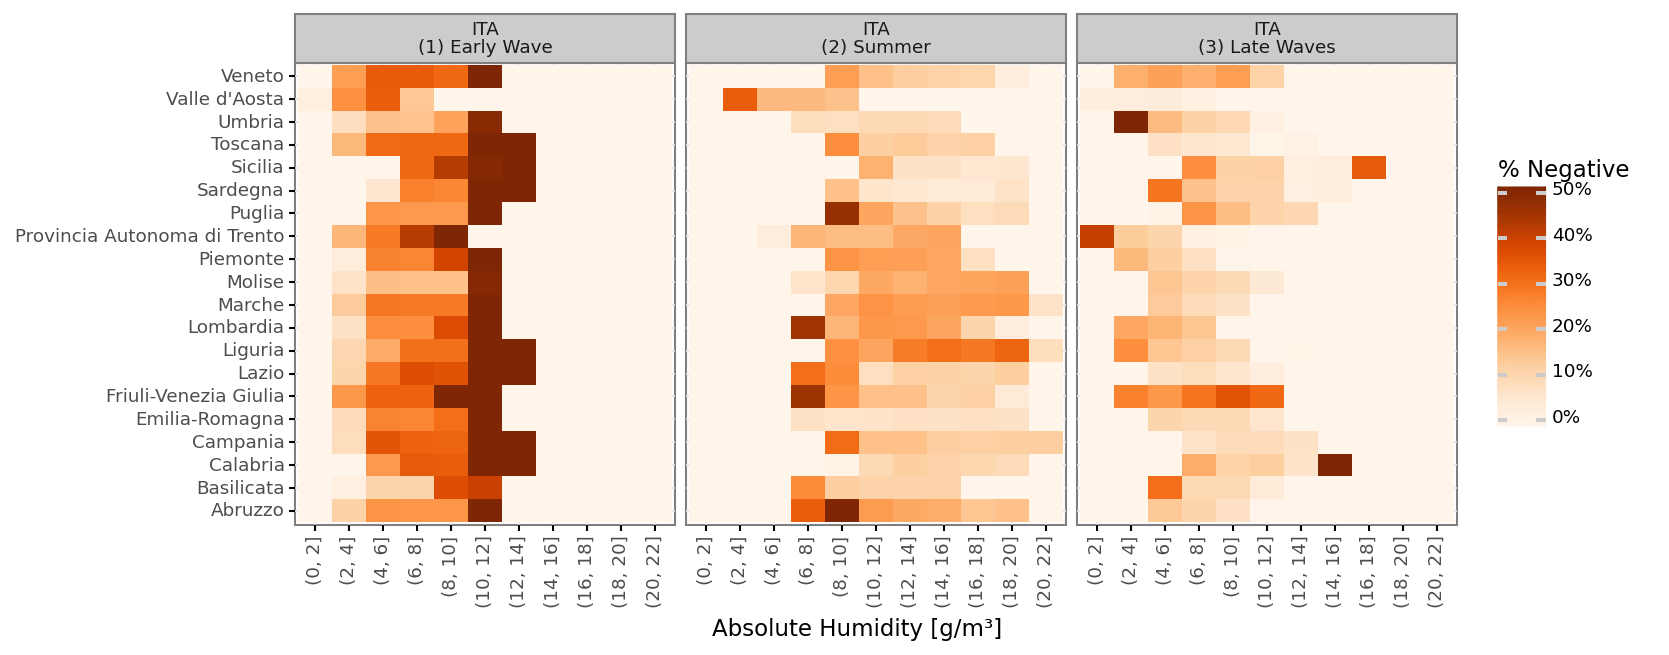

In [106]:
for country in ['DEU', 'ESP', 'ITA']:
    f = (ranges_df
     .loc[lambda dd: dd['var']==wv]
     .loc[lambda dd: dd['country']==country]
     .loc[lambda dd: dd.direction=='Negative']
      .pipe(lambda dd: p9.ggplot(dd)
                   + p9.aes('cat_value', 'region', fill='freq')
                   + p9.geom_tile()
                   + p9.facet_wrap(['country', 'period'], ncol=3)
                   + p9.theme(figure_size=(10, 4), axis_text_x=p9.element_text(rotation=90))
                   + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .5))
                   + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
                   )
    )
    f.draw().savefig(f'../../results/figures/ranges_{country}_periods_heatmap_ah.pdf', bbox_inches='tight')
plt.show()

/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 3 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/ah_t_ITA_ESP_distributions.pdf


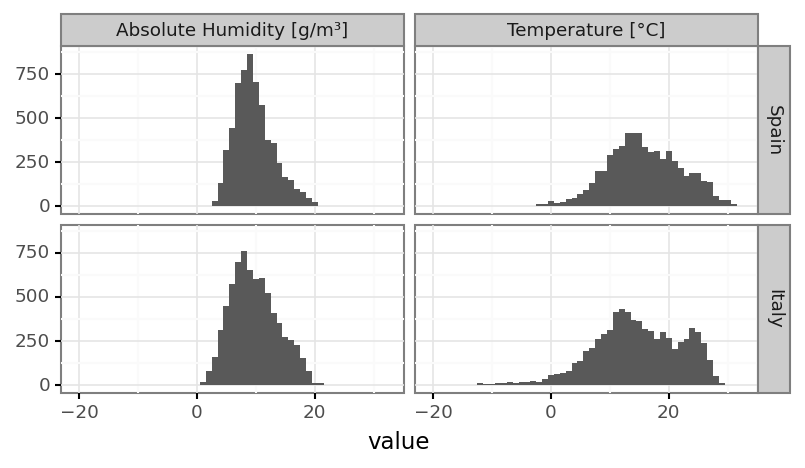

<ggplot: (8774517602082)>

In [50]:
min_bin = 0
max_bin = 22
bin_size = 2
f = (weighted_climate_df
 .loc[lambda dd: dd.region.isin(regions_country)]
 .assign(country=lambda dd: dd.region.apply(lambda x: regions_country[x]))
 .loc[lambda dd: dd.country.isin(['ESP', 'ITA'])]
 .loc[lambda dd: dd.variable.isin(['temperature', 'absolute_humidity'])]
 .assign(country=lambda dd: dd.country.replace({'ITA': 'Italy', 'ESP': 'Spain'}))
 .assign(country=lambda dd: pd.Categorical(dd.country, categories=['Spain', 'Italy'], ordered=True))
 .assign(variable=lambda dd: dd.variable.map(CV_LABELS))
 .assign(cat_value=lambda dd: pd.cut(dd.value, bins=list(range(min_bin, max_bin + bin_size, bin_size)),
                                                  precision=0))
 .pipe(lambda dd: p9.ggplot(dd) + p9.aes('value') + p9.geom_histogram(binwidth=1)
       + p9.facet_grid(['country', 'variable'])
       + p9.theme(figure_size=(6, 3))
       + p9.labs(x='value', y=''))
)

p9.ggsave(f, '../../results/figures/ah_t_ITA_ESP_distributions.pdf')
f

In [100]:
min_bin = 0
max_bin = 22
bin_size = 2
f = (weighted_climate_df
 .loc[lambda dd: dd.region.isin(regions_country)]
 .loc[lambda dd: dd['period'].str.contains('3')]
 .loc[lambda dd: dd.variable=='absolute_humidity']
 .assign(country=lambda dd: dd.region.apply(lambda x: regions_country[x]))
 .loc[lambda dd: dd.country.isin(['ESP', 'ITA'])]
  .assign(country=lambda dd: dd.country.replace({'ITA': 'Italy', 'ESP': 'Spain'}))
 .assign(country=lambda dd: pd.Categorical(dd.country, categories=['Spain', 'Italy'], ordered=True))
 .loc[lambda dd: dd.variable.isin(['temperature', 'absolute_humidity'])]
 .assign(cat_value=lambda dd: pd.cut(dd.value, bins=list(range(min_bin, max_bin + bin_size, bin_size)),
                                                  precision=0))
 .pipe(lambda dd: p9.ggplot(dd) + p9.aes('value') + p9.geom_histogram(binwidth=1)
       + p9.facet_grid(['country', 'period'])
       + p9.theme(figure_size=(3, 4))
       + p9.labs(x=CV_LABELS['absolute_humidity'], y=''))
)
p9.ggsave(f, '../../results/figures/ah_t_ITA_ESP_distributions_periods.pdf')


/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 3 x 4 in image.
/home/afontal/.cache/pypoetry/virtualenvs/covid-climate-signatures-fALnqXQj-py3.8/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ../../results/figures/ah_t_ITA_ESP_distributions_periods.pdf


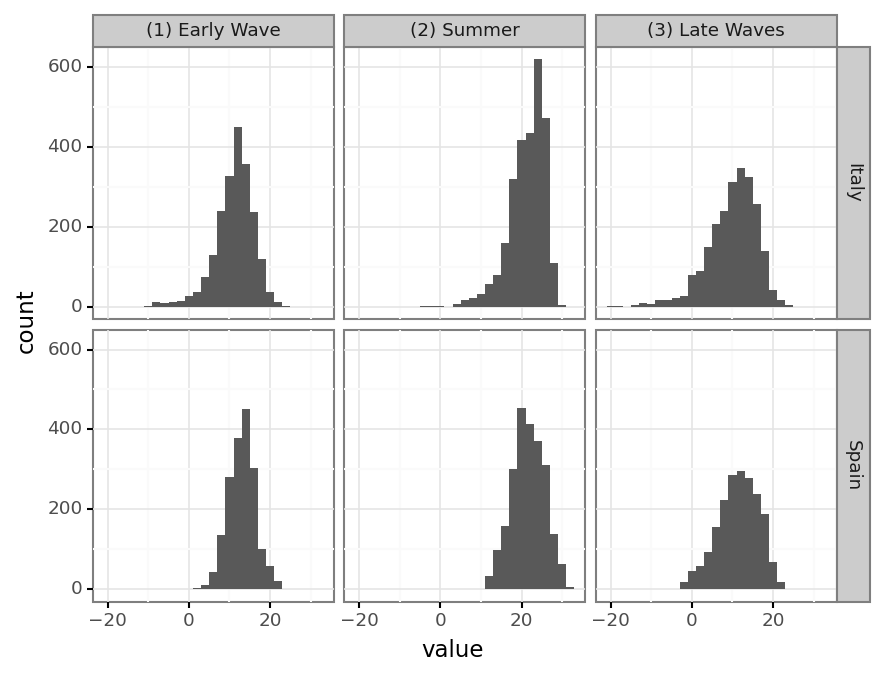

<ggplot: (8774509384665)>

In [102]:
f = (weighted_climate_df
 .loc[lambda dd: dd.region.isin(regions_country)]
 .loc[lambda dd: dd.variable=='temperature']
 .assign(country=lambda dd: dd.region.apply(lambda x: regions_country[x]))
 .loc[lambda dd: dd.country.isin(['ESP', 'ITA'])]
   .assign(country=lambda dd: dd.country.replace({'ITA': 'Italy', 'ESP': 'Spain'}))

 .loc[lambda dd: dd.variable.isin(['temperature', 'absolute_humidity'])]

 .pipe(lambda dd: p9.ggplot(dd) + p9.aes('value') + p9.geom_histogram(binwidth=2)
       + p9.facet_grid(['country', 'period']))
)
f